# Import necessary modules

In [ ]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Setting the input and output directory
INPUT_DIR = '/kaggle/icg'
OUTPUT_DIR = '/kaggle/icg/working'

In [ ]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/434 [00:00<?, ?it/s]

In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [ ]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Loading Caption Data

In [ ]:
with open(os.path.join(INPUT_DIR, 'caption.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/1726 [00:00<?, ?it/s]

Total number of captions: 1724


In [ ]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
image_to_captions_mapping['10']

['Taj Mahal  in Agra  Indias glory ',
 'Taj Mahal located in India  UNESCO Heritage Site',
 'Taj Mahal seen in Agra  esteem of India',
 'Taj Mahal situated in India   Indias Enduring Monument ']

In [ ]:
# preprocess the text
clean(image_to_captions_mapping)

In [ ]:
# after preprocess of text
image_to_captions_mapping['10']

['startseq taj mahal in agra indias glory endseq',
 'startseq taj mahal located in india unesco heritage site endseq',
 'startseq taj mahal seen in agra esteem of india endseq',
 'startseq taj mahal situated in india indias enduring monument endseq']

In [ ]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [ ]:
all_captions[:10]

['startseq taj mahal situated in india monument of love endseq',
 'startseq taj mahal found in agra symbol of eternal love endseq',
 'startseq taj mahal nested in agra monument to eternal love endseq',
 'startseq taj mahal positioned in agra icon of mugahal style endseq',
 'startseq taj mahal located in india magnificent mughal architecture endseq',
 'startseq taj mahal situated in agra majestic mughal monument endseq',
 'startseq taj mahal nested in india iconic mughal monument endseq',
 'startseq taj mahal positioned in agra eternal beauty endseq',
 'startseq taj mahal located in india immortal beauty endseq',
 'startseq taj mahal situated in agra ageless beauty endseq']

In [ ]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [ ]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 704
Maximum Caption Length: 19


# Train Test Split

In [ ]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys:
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

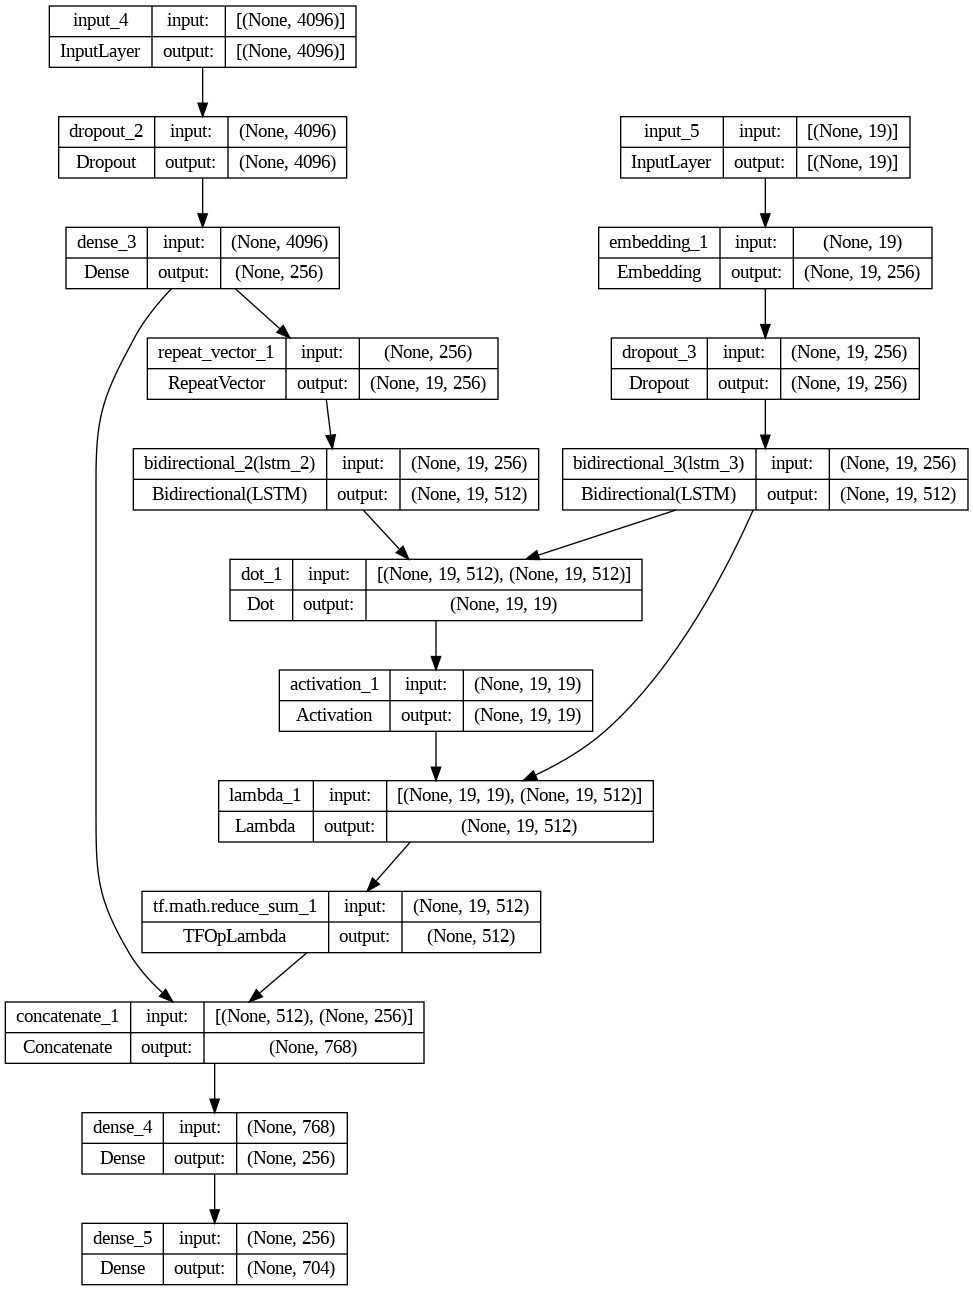

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

In [ ]:
# Set the number of epochs, batch size
epochs = 25
batch_size = 16

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/25
25/25 [==============================] - 30s 518ms/step - loss: 4.2498 - val_loss: 7.3715
Epoch 2/25
25/25 [==============================] - 9s 337ms/step - loss: 3.0664 - val_loss: 6.6819
Epoch 3/25
25/25 [==============================] - 9s 353ms/step - loss: 2.5443 - val_loss: 7.8151
Epoch 4/25
25/25 [==============================] - 10s 385ms/step - loss: 2.0377 - val_loss: 8.7911
Epoch 5/25
25/25 [==============================] - 7s 278ms/step - loss: 1.6520 - val_loss: 9.7641
Epoch 6/25
25/25 [==============================] - 9s 351ms/step - loss: 1.4921 - val_loss: 14.2210
Epoch 7/25
25/25 [==============================] - 9s 373ms/step - loss: 1.3916 - val_loss: 10.3606
Epoch 8/25
25/25 [==============================] - 7s 281ms/step - loss: 1.2699 - val_loss: 13.4956
Epoch 9/25
25/25 [==============================] - 9s 366ms/step - loss: 1.0065 - val_loss: 13.8036
Epoch 10/25
25/25 [==============================] - 9s 347ms/step - loss: 0.9948 - val_loss: 

In [ ]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

# Captions Generation

In [ ]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'

    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word to the caption
        caption += " " + predicted_word

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [ ]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/44 [00:00<?, ?it/s]

KeyError: '1026685415_0431cbf574'

# Predicting captions for Images

In [ ]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq taj mahal in agra indias glory endseq
startseq taj mahal located in india unesco heritage site endseq
startseq taj mahal seen in agra esteem of india endseq
startseq taj mahal situated in india indias enduring monument endseq
--------------------Predicted--------------------
startseq taj mahal seen in agra esteem of india endseq


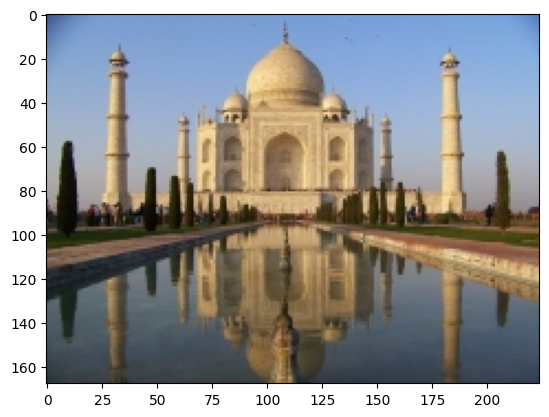

In [ ]:
generate_caption("10.jpg")

---------------------Actual---------------------
startseq charminar located in hyderabad monument of hyderabads cultural grandeur endseq
startseq charminar located in hyderabad icon of islamic heritage in deccan endseq
startseq charminar located in hyderabad architectural wonder of telangana endseq
startseq charminar located in hyderabad landmark of hyderabads timeless elegance endseq
--------------------Predicted--------------------
startseq taj mahal located in india icon of love endseq


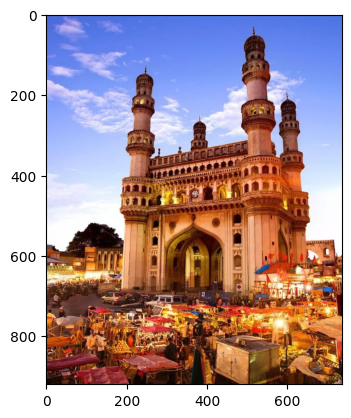

In [ ]:
generate_caption("200.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in front of the camera in front of rainbow painting endseq


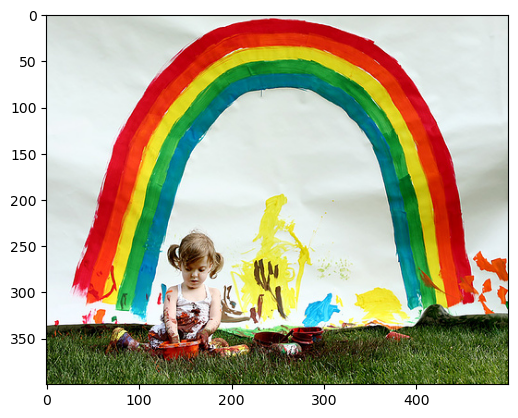

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man stands in front of very tall building endseq


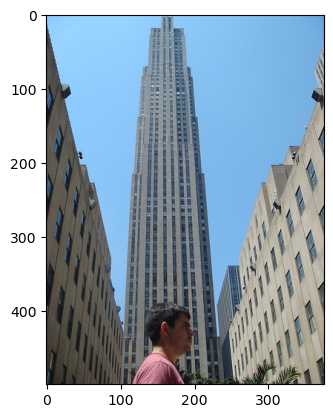

In [ ]:
generate_caption("1032460886_4a598ed535.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq three dogs are standing in the grass and person is sitting next to them endseq


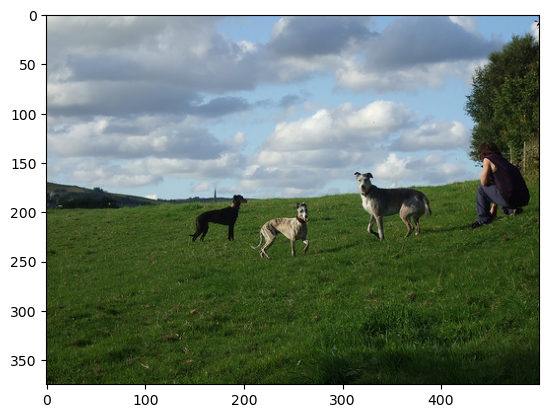

In [ ]:
generate_caption("1032122270_ea6f0beedb.jpg")